In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ed=[]
for year in [2012, 2013, 2014, 2015, 2016]:
  ed=ed+[pd.read_csv(
    '/content/drive/MyDrive/파이썬코드/전력량예측/shikoku_electricity_%d.csv' % year,
    skiprows=3,
    names=['DATE', 'TIME', 'consumption'],
    parse_dates={'date_hour': ['DATE', 'TIME']},
    index_col='date_hour')]
elec_data = pd.concat(ed)

In [4]:
print(elec_data.shape)
elec_data

(32856, 1)


,consumption
date_hour,
2012-07-02 00:00:00,261
2012-07-02 01:00:00,256
2012-07-02 02:00:00,269
2012-07-02 03:00:00,289
2012-07-02 04:00:00,297
...,...
2016-03-31 19:00:00,329
2016-03-31 20:00:00,317
2016-03-31 21:00:00,298


In [5]:
# 기상 데이터를 읽어 들이기
tmp = pd.read_csv(
    '/content/drive/MyDrive/파이썬코드/전력량예측/47891_city.csv',
    parse_dates={'date_hour': ["일시"]},
    index_col = "date_hour",
    na_values="×"
)
del tmp["시"]  # [시] 열은 사용하지 않으므로 삭제

In [6]:
print(tmp.shape)
tmp.sort_index()

(32856, 8)


,기압(hPa)현지,기압(hPa)해수면,강수량(mm),기온(℃),습도(％),풍향・풍속(m/s)풍속,풍향・풍속(m/s)풍향,일조시간(h)
date_hour,,,,,,,,
2012-07-02 01:00:00,1002.5,1004.1,--,24.5,67.0,3.7,西南西,NaN
2012-07-02 02:00:00,1002.7,1004.3,--,24.1,69.0,3.4,西南西,NaN
2012-07-02 03:00:00,1003.0,1004.6,--,23.6,74.0,1.9,西南西,NaN
2012-07-02 04:00:00,1002.9,1004.5,--,23.3,77.0,1.9,南西,NaN
2012-07-02 05:00:00,1003.1,1004.7,--,23.0,81.0,1.0,南南西,0.0
...,...,...,...,...,...,...,...,...
2016-03-31 20:00:00,1014.7,1016.4,0.0,16.5,65.0,1.0,東,NaN
2016-03-31 21:00:00,1014.6,1016.3,0.0,15.8,70.0,1.2,南南東,NaN
2016-03-31 22:00:00,1014.5,1016.2,0.0,15.1,77.0,1.0,南東,NaN


In [7]:
# 열 이름 영어로 변경
columns = {
    "강수량(mm)": "rain",
    "기온(℃)": "temperature",
    "일조시간(h)": "sunhour",
    "습도(％)": "humid",
}
tmp.rename(columns=columns, inplace=True)

In [8]:
print(tmp.shape)
tmp

(32856, 8)


,기압(hPa)현지,기압(hPa)해수면,rain,temperature,humid,풍향・풍속(m/s)풍속,풍향・풍속(m/s)풍향,sunhour
date_hour,,,,,,,,
2013-11-28 01:00:00,1012.1,1013.8,--,11.9,48.0,7.0,西,NaN
2013-11-28 02:00:00,1012.2,1013.9,--,11.5,50.0,7.4,西,NaN
2013-11-28 03:00:00,1012.3,1014.0,--,10.9,47.0,6.8,西,NaN
2013-11-28 04:00:00,1012.6,1014.3,--,10.3,44.0,6.9,西,NaN
2013-11-28 05:00:00,1012.7,1014.4,--,10.0,46.0,6.1,西,NaN
...,...,...,...,...,...,...,...,...
2012-07-06 20:00:00,1000.7,1002.3,1.0,27.6,78.0,4.0,西,0.0
2012-07-06 21:00:00,999.7,1001.3,10.0,23.9,82.0,7.8,西南西,NaN
2012-07-06 22:00:00,998.8,1000.4,1.5,23.6,87.0,3.0,西南西,NaN


In [9]:
# 기상 데이터와 전력 소비량 데이터를 일단 통합해 시간축을 맞추고 다시 분할
# join 하면 인덱스를 맞춰서 결합하게 됨
takamatsu = elec_data.join(tmp["temperature"]).dropna().to_numpy()
#takamatsu = elec_data.join(tmp["temperature"]).dropna().as_matrix()

takamatsu_elec = takamatsu[:, 0:1]
takamatsu_wthr = takamatsu[:, 1:]
print(elec_data.shape)

(32856, 1)


In [10]:
print(takamatsu.shape)
print(takamatsu_elec.shape)
print(takamatsu_wthr.shape)
pd.DataFrame(takamatsu).shape

(32855, 2)
(32855, 1)
(32855, 1)


(32855, 2)

In [11]:
import matplotlib.pyplot as plt

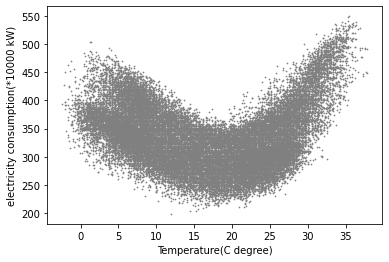

In [12]:
plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.scatter(takamatsu_wthr, takamatsu_elec, s=0.5,
            color="gray", label='electricity consumption(measured)')

####SVR을 이용한 전력 소비량 추정

> SVM 과 유사하지만 Regression 형태로 구현



In [ ]:
from sklearn.model_selection import KFold
import sklearn.svm

In [ ]:
data_count = len(takamatsu_elec)

# 교차검증의 준비, cross_validation
# 전체 데이터를 n_splits만큼 분할하고
# n_splits만큼 검증 시행
# n_splits이 5라고 하면 전체 데이터를 5블럭으로 나누고
# 한블럭을 테스트, 나머지를 학습용으로 사용
# 5번 검증을 반복하는데 각각 다른 블럭을 테스트용으로 사용
kf = KFold(n_splits=5)

model = sklearn.svm.SVR()
# 교차검증 실시(모든 패턴을 실시)
for train, test in kf.split(takamatsu_elec):
    x_train = takamatsu_wthr[train]
    x_test = takamatsu_wthr[test]
    y_train = takamatsu_elec[train]
    y_test = takamatsu_elec[test]

    # -- SVR --
    # 데이터를 flatten()하면 다차원 배열을 1차원으로 변환
    # 기존의 데이터도 열이 하나였지만 1차원으로 취급하지 않고 열이 하나인 다차원 취급
    # 데이터를 모델에 적용하기 전에 flatten하는 과정 필요
    model = sklearn.svm.SVR()
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    model.fit(x_train, y_train)
    print ("SVR: Training Score = %f, Testing(Validate) Score = %f" %
           (model.score(x_train, y_train), model.score(x_test, y_test)))
    # svm.SVR.score()는 R-squeared

SVR: Training Score = 0.474706, Testing(Validate) Score = 0.408431
SVR: Training Score = 0.455393, Testing(Validate) Score = 0.550360
SVR: Training Score = 0.473500, Testing(Validate) Score = 0.493402
SVR: Training Score = 0.487261, Testing(Validate) Score = 0.384120
SVR: Training Score = 0.490571, Testing(Validate) Score = 0.415260


In [ ]:
import numpy as np

In [ ]:
px = np.arange(takamatsu_wthr.min(), takamatsu_wthr.max(), 0.01)[:, np.newaxis]
py = model.predict(px)

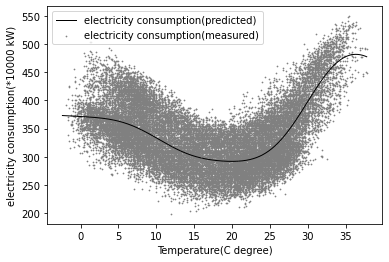

In [ ]:
plt.xlabel('Temperature(C degree)')
plt.ylabel('electricity consumption(*10000 kW)')

plt.plot(px, py, color="black", linewidth=1,
         label='electricity consumption(predicted)')

plt.scatter(takamatsu_wthr[train], takamatsu_elec[train], s=0.5,
            color="gray", label='electricity consumption(measured)')
plt.legend(loc='upper left')

실제 전력 소비량과 예측 전력 소비량의 상관관계

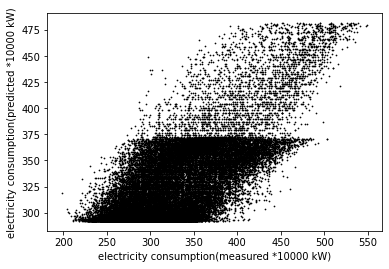

In [ ]:
plt.xlabel('electricity consumption(measured *10000 kW)')
plt.ylabel('electricity consumption(predicted *10000 kW)')

predicted = model.predict(takamatsu_wthr)

plt.scatter(takamatsu_elec, predicted, s=0.5, color="black")

동일한 20도라도 봄가을 낮 기온과 여름의 무더운 온기가 남은 심야 기온에서 소비 전력은 다를 것이다.

비가 많이 온 날 20도와 맑은 날 20도도 다를 것으로 예측된다.

온도 이외의 다른 기상 정보를 추가해보자.

In [ ]:
# 연습용 셀
for train, test in kf.split(takamatsu_elec):
    x_train = takamatsu_wthr[train]
    x_test = takamatsu_wthr[test]
    y_train = takamatsu_elec[train]
    y_test = takamatsu_elec[test]
    print()
    print("x_train: ",x_train.shape)
    print("x_test : ",x_test.shape)
    print("y_train: ",y_train.shape)
    print("y_test : ",y_test.shape)
    print()
    print("x_train_flatten: ",x_train.flatten().shape)
    print("x_test_flatten : ",x_test.flatten().shape)
    print("y_train_flatten: ",y_train.flatten().shape)
    print("y_test_flatten : ",y_test.flatten().shape)
    print()
    break

from sklearn.model_selection import cross_val_score #score evaluation
kf = KFold(n_splits=5)
model = sklearn.svm.SVR()
# 2번째 인자는 다차원 가능
# 3번째 인자는 flatten으로 1차원 데이터가 나와야함
cv_result = cross_val_score(model,takamatsu_elec,takamatsu_wthr.flatten(), cv = kf)
cv_result


x_train:  (26284, 1)
x_test :  (6571, 1)
y_train:  (26284, 1)
y_test :  (6571, 1)

x_train_flatten:  (26284,)
x_test_flatten :  (6571,)
y_train_flatten:  (26284,)
y_test_flatten :  (6571,)



array([ 0.07344576, -0.49584286, -0.06481486, -0.1040452 ,  0.00578974])